阅读内容和风格图像

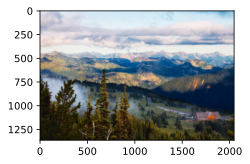

In [2]:
%matplotlib inline
import torch 
import torchvision
from torch import nn 
from d2l import torch as d2l 

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

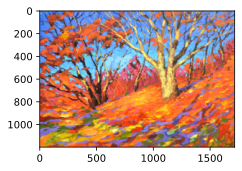

In [28]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

预处理和后处理

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)  # 标准化
    ])
    return transforms(img).unsqueeze(0)

In [5]:
def postprocess(img):
    """将输出图像中的像素值还原回标准化之前的值"""
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1) # 限制值在[0, 1]区间之内
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

提取图像特征

In [6]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

d:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\31718/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100.0%


In [8]:
# 越靠近输入层，越容易提取图像的局部细节信息
# 越靠近输出层，越容易提取图像的全局信息
# VGG网络使用了5个卷积块
# 选择每个卷积块的第一个卷积层作为风格层
# 选择第四卷积块的最后一个卷积层作为内容层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [9]:
# 保留需要用到的VGG的所有层
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

In [10]:
def extract_features(X, content_layers, style_layers):
    """获得内容层和风格层的输出"""
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [11]:
def get_contents(image_shape, device):
    """对内容图像提取内容特征"""
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    """对风格图像提取风格特征"""
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

定义损失函数

内容损失

In [ ]:
def content_loss(Y_hat, Y):
    """内容损失"""
    # 从动态计算梯度的树中分离目标，是定值，而不是变量
    return torch.square(Y_hat - Y.detach()).mean()

风格损失

In [ ]:
def gram(X):
    """格拉姆矩阵, i行j列的元素, 表示通道i和通道j上风格特征的相关性"""
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [14]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

全变分损失<br>
假设$x_{i,j}$表示坐标(i,j)处的像素值<br>
$$\sum_{i,j}|x_{i,j}-x_{i+1,j}| + |x_{i, j}-x_{i, j+1}|$$
有时，学习的合成图像中有大量高频噪点，即特别亮或特别暗的像素<br>
可以通过降低全变分损失，尽可能的使邻近的像素值接近，达到去噪的目的

In [15]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [24]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    """损失函数"""
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l  

内容损失：使合成图像与内容图像在内容特征上接近<br>
风格损失：使合成图像与风格图像在风格特征上接近<br>
全变分损失：有助于减少合成图像中的噪点<br>

初始化合成图像

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape)) # 将合成图像视为模型参数
    
    def forward(self):
        return self.weight

In [19]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)    # 将合成图像初始化为图像X
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]  # 预先计算好各风格层的格拉姆矩阵
    return gen_img(), styles_Y_gram, trainer


训练模型

In [20]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8) # 学习率每过decay_epoch, 即*0.8来衰减
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], 
                            legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers) # 内容层输出, 风格层输出
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch+1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X

In [21]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

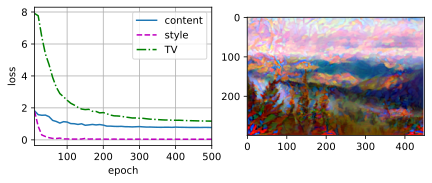

In [25]:
device, image_shape = try_xpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

尝试

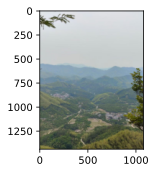

In [40]:
content_img = d2l.Image.open('../img/mountain.jpg')
d2l.plt.imshow(content_img);

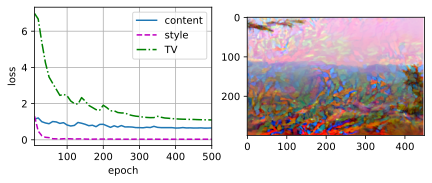

In [41]:
device, image_shape = try_xpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

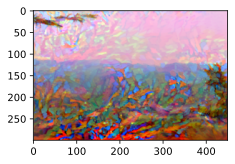

In [42]:
d2l.plt.imshow(postprocess(output));

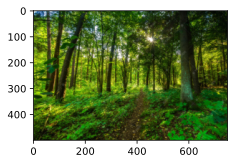

In [49]:
content_img = d2l.Image.open('../img/forest.jpg')
d2l.plt.imshow(content_img);

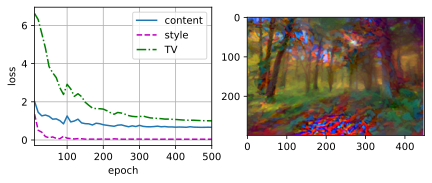

In [50]:
device, image_shape = try_xpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [ ]:
d2l.plt.imshow(postprocess(output));